In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada VGG16 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJO/Trabajos_ciencia_de_datos/Clasificacion_imagenes/Dataset_bien.zip

Ajustando los datos de la BD


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'Dataset_bien/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Dataset_bien/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Dataset_bien/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1158 files belonging to 4 classes.
Found 252 files belonging to 4 classes.
Found 287 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
conv_base.trainable = False
# conv_base.trainable = True
# for layer in conv_base.layers[:-4]:
#     layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(768, kernel_regularizer=regularizers.l1_l2(0.01))(x) # Regularizador para disminuir el overfiting
x = layers.Dropout(0.5)(x) # Dropout para reducir el overfiting
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Fijar los hiperparámetros y entrenar la red

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=30,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/30


37/37 [==============================] - 33s 455ms/step - loss: 1043.8721 - accuracy: 0.3169 - val_loss: 1030.1567 - val_accuracy: 0.4563
Epoch 2/30
37/37 [==============================] - 13s 313ms/step - loss: 1023.1964 - accuracy: 0.3921 - val_loss: 1011.4556 - val_accuracy: 0.5079
Epoch 3/30
37/37 [==============================] - 13s 311ms/step - loss: 1004.0065 - accuracy: 0.4352 - val_loss: 993.1610 - val_accuracy: 0.5198
Epoch 4/30
37/37 [==============================] - 13s 311ms/step - loss: 984.8859 - accuracy: 0.4922 - val_loss: 973.7281 - val_accuracy: 0.5159
Epoch 5/30
37/37 [==============================] - 13s 314ms/step - loss: 965.5972 - accuracy: 0.4775 - val_loss: 954.8983 - val_accuracy: 0.5397
Epoch 6/30
37/37 [==============================] - 13s 317ms/step - loss: 946.4284 - accuracy: 0.5121 - val_loss: 935.5447 - val_accuracy: 0.5873
Epoch 7/30
37/37 [==============================] - 13s 313ms/step - loss: 927.6879 - accuracy: 0.5345 - val_loss: 916.9810 

Visualizando la pérdida y el accuracy durante el entrenamiento


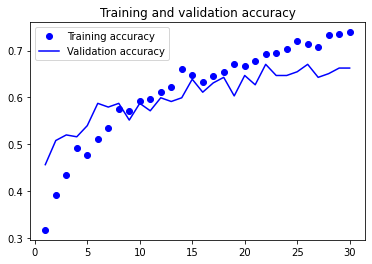

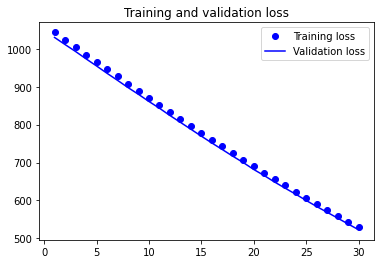

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 6s 569ms/step - loss: 521.9429 - accuracy: 0.6794


[521.94287109375, 0.6794425249099731]

Fijar los hiperparámetros y entrenar la red

In [ ]:
conv_base.trainable = True

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=2,  #30
    batch_size=128,
    validation_data=validation_dataset)

Epoch 1/2


37/37 [==============================] - 33s 592ms/step - loss: 509.4150 - accuracy: 0.6753 - val_loss: 500.3603 - val_accuracy: 0.6389
Epoch 2/2
37/37 [==============================] - 20s 483ms/step - loss: 491.0297 - accuracy: 0.6978 - val_loss: 481.9688 - val_accuracy: 0.6230


Visualizando la pérdida y el accuracy durante el entrenamiento


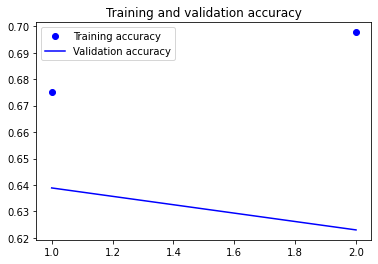

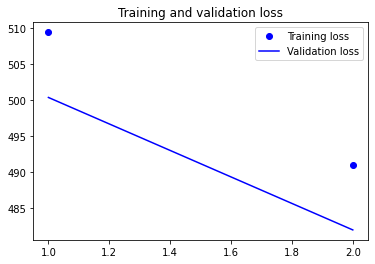

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 89ms/step - loss: 481.7899 - accuracy: 0.6725


[481.7899169921875, 0.6724738478660583]

In [ ]:
conv_base.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=5,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/5


37/37 [==============================] - 17s 314ms/step - loss: 468.7798 - accuracy: 0.6546 - val_loss: 458.5211 - val_accuracy: 0.6746
Epoch 2/5
37/37 [==============================] - 13s 311ms/step - loss: 449.9371 - accuracy: 0.6649 - val_loss: 440.9195 - val_accuracy: 0.6627
Epoch 3/5
37/37 [==============================] - 13s 312ms/step - loss: 432.3821 - accuracy: 0.6770 - val_loss: 423.5245 - val_accuracy: 0.6746
Epoch 4/5
37/37 [==============================] - 13s 312ms/step - loss: 415.1824 - accuracy: 0.6926 - val_loss: 406.6046 - val_accuracy: 0.6825
Epoch 5/5
37/37 [==============================] - 13s 311ms/step - loss: 398.3408 - accuracy: 0.7047 - val_loss: 390.0451 - val_accuracy: 0.6786


Visualizando la pérdida y el accuracy durante el entrenamiento


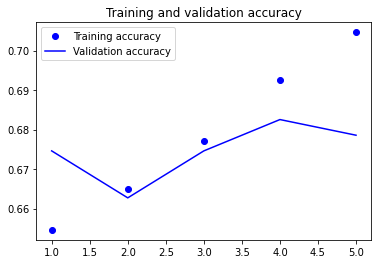

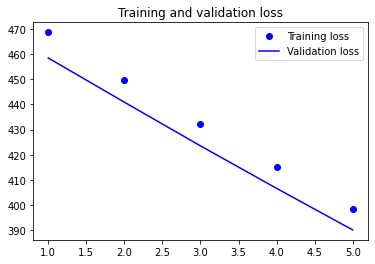

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 90ms/step - loss: 389.8141 - accuracy: 0.7108


[389.8141174316406, 0.7108014225959778]

In [ ]:
conv_base.trainable = True

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=2,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/2


37/37 [==============================] - 25s 475ms/step - loss: 377.8748 - accuracy: 0.6753 - val_loss: 368.2829 - val_accuracy: 0.6667
Epoch 2/2
37/37 [==============================] - 19s 477ms/step - loss: 359.8480 - accuracy: 0.7211 - val_loss: 351.0197 - val_accuracy: 0.6627


Visualizando la pérdida y el accuracy durante el entrenamiento


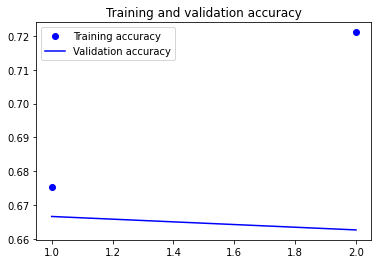

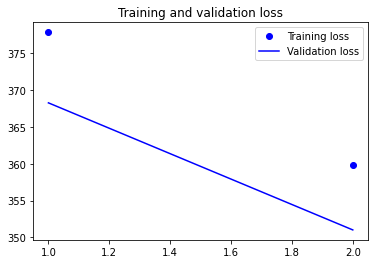

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 95ms/step - loss: 350.9164 - accuracy: 0.7038


[350.91644287109375, 0.703832745552063]

In [ ]:
conv_base.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=5,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/5


37/37 [==============================] - 17s 319ms/step - loss: 338.8769 - accuracy: 0.7453 - val_loss: 329.4196 - val_accuracy: 0.7024
Epoch 2/5
37/37 [==============================] - 14s 333ms/step - loss: 321.2593 - accuracy: 0.7573 - val_loss: 312.9725 - val_accuracy: 0.7222
Epoch 3/5
37/37 [==============================] - 18s 386ms/step - loss: 305.0960 - accuracy: 0.7936 - val_loss: 297.0570 - val_accuracy: 0.7143
Epoch 4/5
37/37 [==============================] - 13s 309ms/step - loss: 289.3761 - accuracy: 0.7798 - val_loss: 281.5912 - val_accuracy: 0.7024
Epoch 5/5
37/37 [==============================] - 13s 314ms/step - loss: 274.0210 - accuracy: 0.7919 - val_loss: 266.4555 - val_accuracy: 0.7183


Visualizando la pérdida y el accuracy durante el entrenamiento


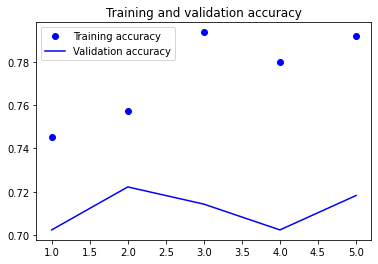

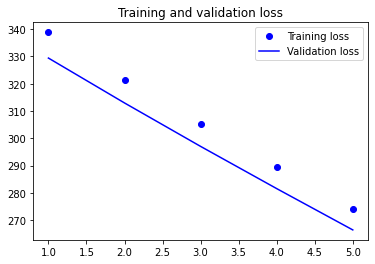

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 89ms/step - loss: 266.3524 - accuracy: 0.7631


[266.3524475097656, 0.7630661725997925]

### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 134ms/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[215  13  10  30]
 [  3 261  33  12]
 [  8  19 205  23]
 [  8  11  12 295]]


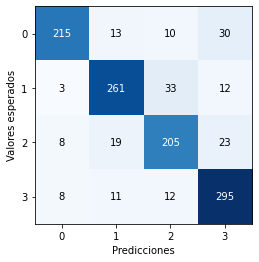

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       268
           1       0.86      0.84      0.85       309
           2       0.79      0.80      0.80       255
           3       0.82      0.90      0.86       326

    accuracy                           0.84      1158
   macro avg       0.85      0.84      0.84      1158
weighted avg       0.85      0.84      0.84      1158



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 25ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[32  3  5 18]
 [ 1 53 11  3]
 [ 3  8 38  6]
 [ 4  4  5 58]]


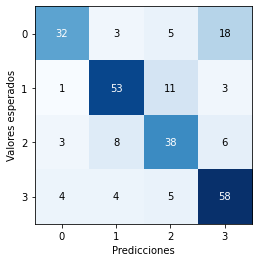

              precision    recall  f1-score   support

           0       0.80      0.55      0.65        58
           1       0.78      0.78      0.78        68
           2       0.64      0.69      0.67        55
           3       0.68      0.82      0.74        71

    accuracy                           0.72       252
   macro avg       0.73      0.71      0.71       252
weighted avg       0.73      0.72      0.72       252



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[51  1  4 10]
 [ 2 58 10  7]
 [ 4 10 38 11]
 [ 1  2  6 72]]


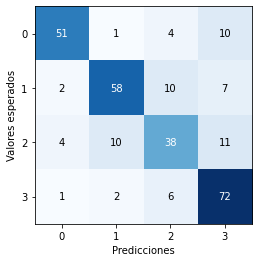

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        66
           1       0.82      0.75      0.78        77
           2       0.66      0.60      0.63        63
           3       0.72      0.89      0.80        81

    accuracy                           0.76       287
   macro avg       0.77      0.75      0.76       287
weighted avg       0.77      0.76      0.76       287



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [ ]:
# #tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
# tflite_models_dir = pathlib.Path(".")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# tflite_model_file = tflite_models_dir/"mnist_model.tflite"
# tflite_model_file.write_bytes(tflite_model)

In [ ]:
tflite_models_dir = pathlib.Path(".")
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"model_VGG16_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

49110964

In [ ]:
# # Convert the model.
# converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model_VGG16.tflite', 'wb') as f:
#   f.write(tflite_model)